# Введение в глубокое обучение
## Занятие 7. Языковое моделирование и RNN


##### Credits: Based on the notebook by [YSDA Practical RL course](https://github.com/yandexdataschool/Practical_RL/)

## План занятия:

0. Повторение. Анализ текстовых данных.
1. Введение в работу с последовательностями.
2. Принципы работы рекуррентных нейронных сетей.
3. Предобработка текстовых данных для задачи языкового моделирования.
4. Построение рекуррентной нейронной сети для задачи языкового моделирования.

## 0. Повторение. Анализ текстовых данных.

На прошлой лекции мы поговорили про работу с текстовыми данными.

Напомним, **текст - это последовательность токенов переменной длины.**

**Токен - это некоторая неделимая единица информации**. Например, в качестве токена могут выступать слова.

Напомним, что токен - это категориальный признак, он принимает различные значения из некоторого конечного множества (например, словаря различных слов).

Ранее мы обсудили, как можно превратить отдельный токен в некоторый числовой вектор, чтобы можно было передавать эту информацию в различные модели, которые работают с числовыми данными. Так же мы обсуждали, как научить сеть понимать некоторую смысловую информацию о токене по его векторному представлению.

На этой лекции мы перейдём на более высокий уровень понимания текстовых данных - на уровень отдельных текстов.

Как мы уже говорили, текст - последовательность, длина которой может быть различна. Например, предложение: "*Мама мыла раму,*" - состоит из 3 слов, а предложение: "*Пойдём сегодня на концерт,*" - это уже последовательность из 4 слов.

Соответственно, если мы представим каждое слово в тексте отдельным вектором фиксированной длины мы не сможем передать всю информацию о тексте в некоторую нейронную сеть. Потому что для формирования сети нам нужны данные фиксированного размера. Соответственно, нужно понять, как на основании известного представления текста в виде последовательности переменной длины из векторов-слов получать некоторое векторное представление фиксированной длины.

На прошлой лекции вы узнали 2 подхода к такому представлению:

1. Представление текста в виде множества токенов (например, мешок слов).

2. Представление текста в виде последовательности токенов.

Первый подход очень прост. Его идея заключается в том, что мы предполагаем, что порядок слов не важен, и текст однозначно представляется набором входящих в него токенов. Таким образом, текст может быть представлен в виде некоторой линейной комбинации векторов, соответствующих входящим в него токенов.

Если мы использовали One-hot или TF-IDF кодирование для отдельного слова, это может быть обычная сумма всех векторов - тогда мы получим классическую модель мешка слов. Например, рассмотрим текст: "***я мыслю следовательно я существую***". Словарь для этого текста будет состоять из четырёх слов: я, мыслю, следовательно, существую. Соответственно, если мы примерим One-hot кодирование, то в качестве векторного представления всего текста мы получим вектор: $[2, 1, 1, 1]$. Т.е. в качестве представления всего текста мы получим вектор, длина которого равна размеру словаря, и на позиции N будет указано число употреблений соответствующего слова в тексте. Аналогично, можно построить векторное представление текста на основании TF-IDF. В этом случае длина векторного представления текста будет так же равна размеру словаря, но на позиции N уже будет указано значение TF-IDF для соответствующего слова в тексте.

Такие подходы, как мы знаем, обладают рядом недостатков. Например, в них будет находиться очень много нулей (в позициях для тех слов из словаря, которых не было в данном тексте). Но это не главное. Главное, что такие подходы не учитывают никакой смысловой информации о входящих в текст токенах.

Можно представить отдельне слова в виде различных моделей, вроде word2vec. Тогда в качестве векторного текста можно взять усреднённый вектор для всех значений векторных представлений всех входящих в текст токенов. Этот подход мы обсудили в конце прошлой лекции. Здесь уже не будет большого количества нулей. Но этот подход обладает следующим недостатком: мы предполагаем, что все слова независимы и никак не учитываем тот факт, что на самом деле, порядок следования слов сильно влияет на смысл всего текста (вспомните прошлую лекцию).

Поэтому, чтобы получить более точную интерпретацию всего текста, нужно пытаться строить некоторое векторное представление с учётом того, в какой последовательности отдельные токены употребляются в тексте. Т.е. нужно научиться строить векторное представление на основании моделей последовательности. Об этом мы и поговорим в этой лекции.



## 1. Введение в работу с последовательностями.


Исследователи выяснили, что хорошим способом анализа последовательностей является новый вид моделей - **рекуррентные нейронные сети**. Сегодня мы познакомимся ближе с этой архитектурой.

RNN – recurrent neural networks.

**Немного истории.**

Исследователи давно пытались понять, как же люди могут сочинять различные тексты, имеющую собствунную структуру (стиль, порядок слов и т.д.).

Первоначально решение такой задачи было предложено с помощью марковских цепей, но они не позволяли добиться хорошего результата. Позже был предложен подход, основанный на RNN. Эти сети позволили лучше гененировать тексты и последовательности, похожие на те примеры, на которых они были обучены. Например, что-то подобное поэзии Шекспира. Или же LaTeX-код статей (который еще и компилируется!). Или код на C/C++ (хотя непонятно, что все-таки он делает :) ).

Но как же это работает? Разберемся далее.

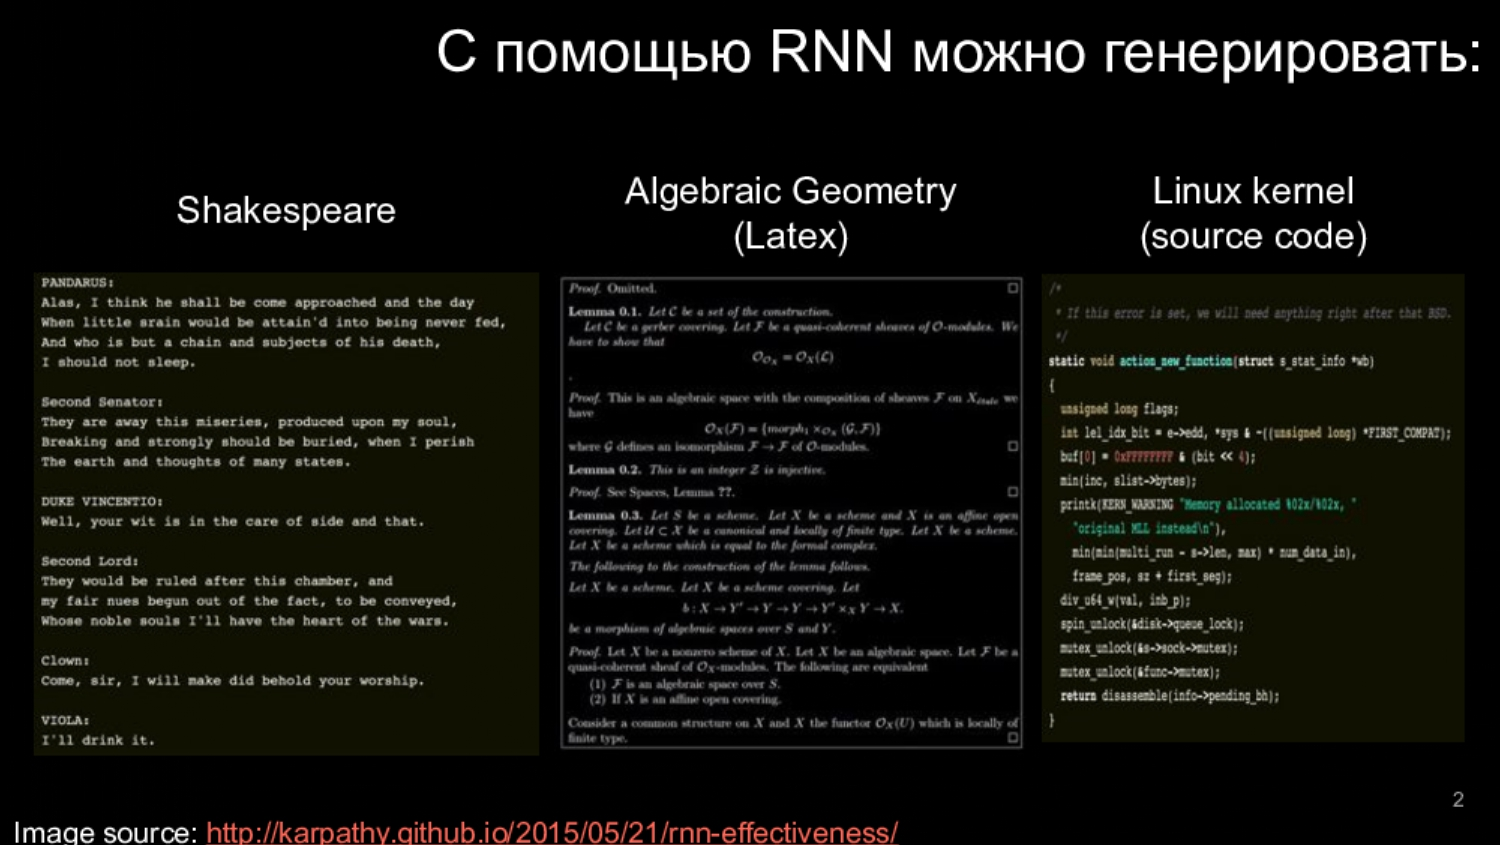

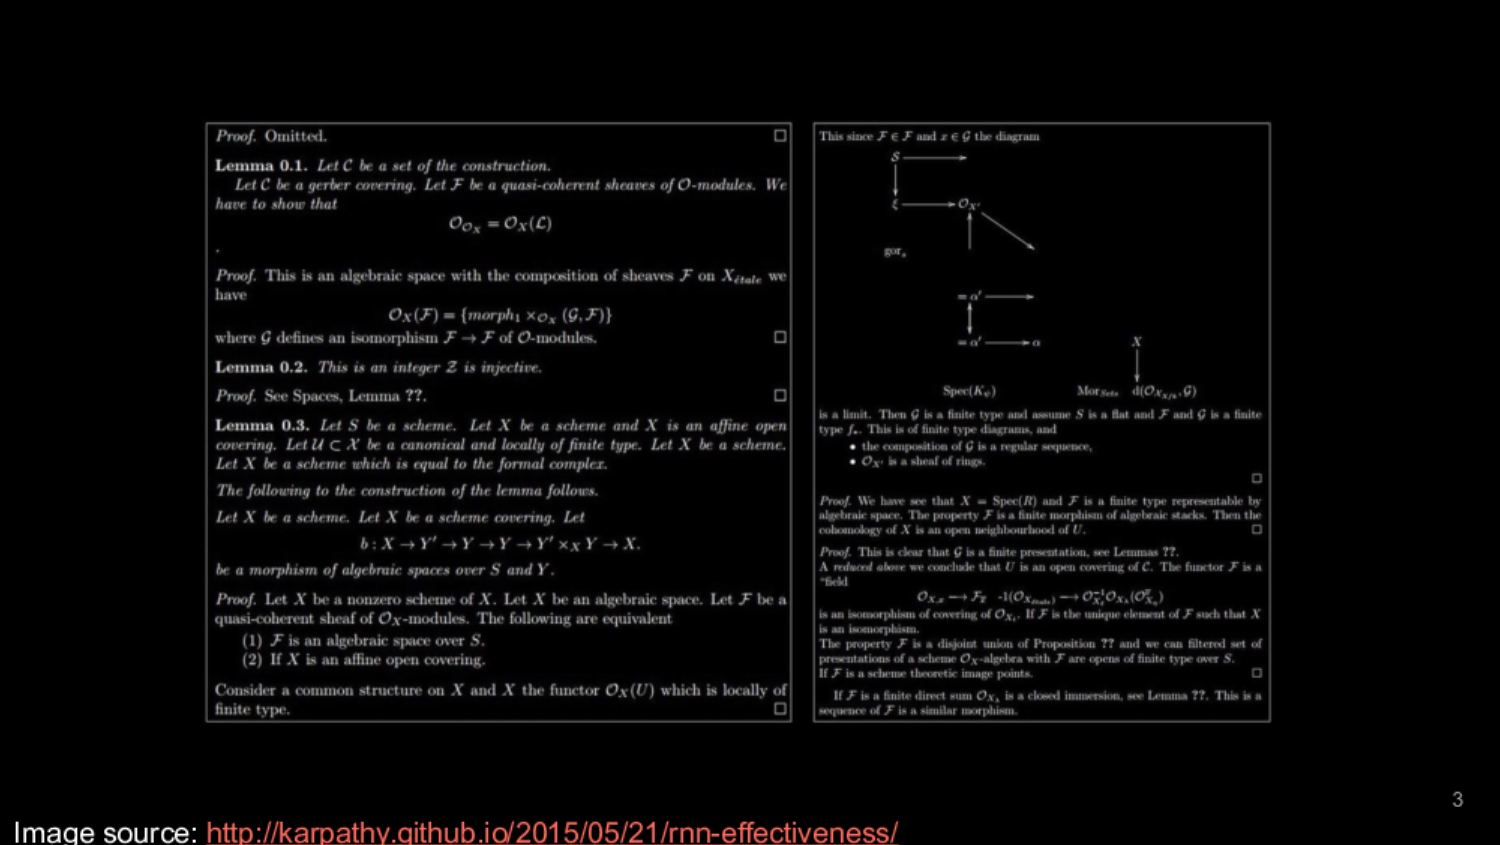

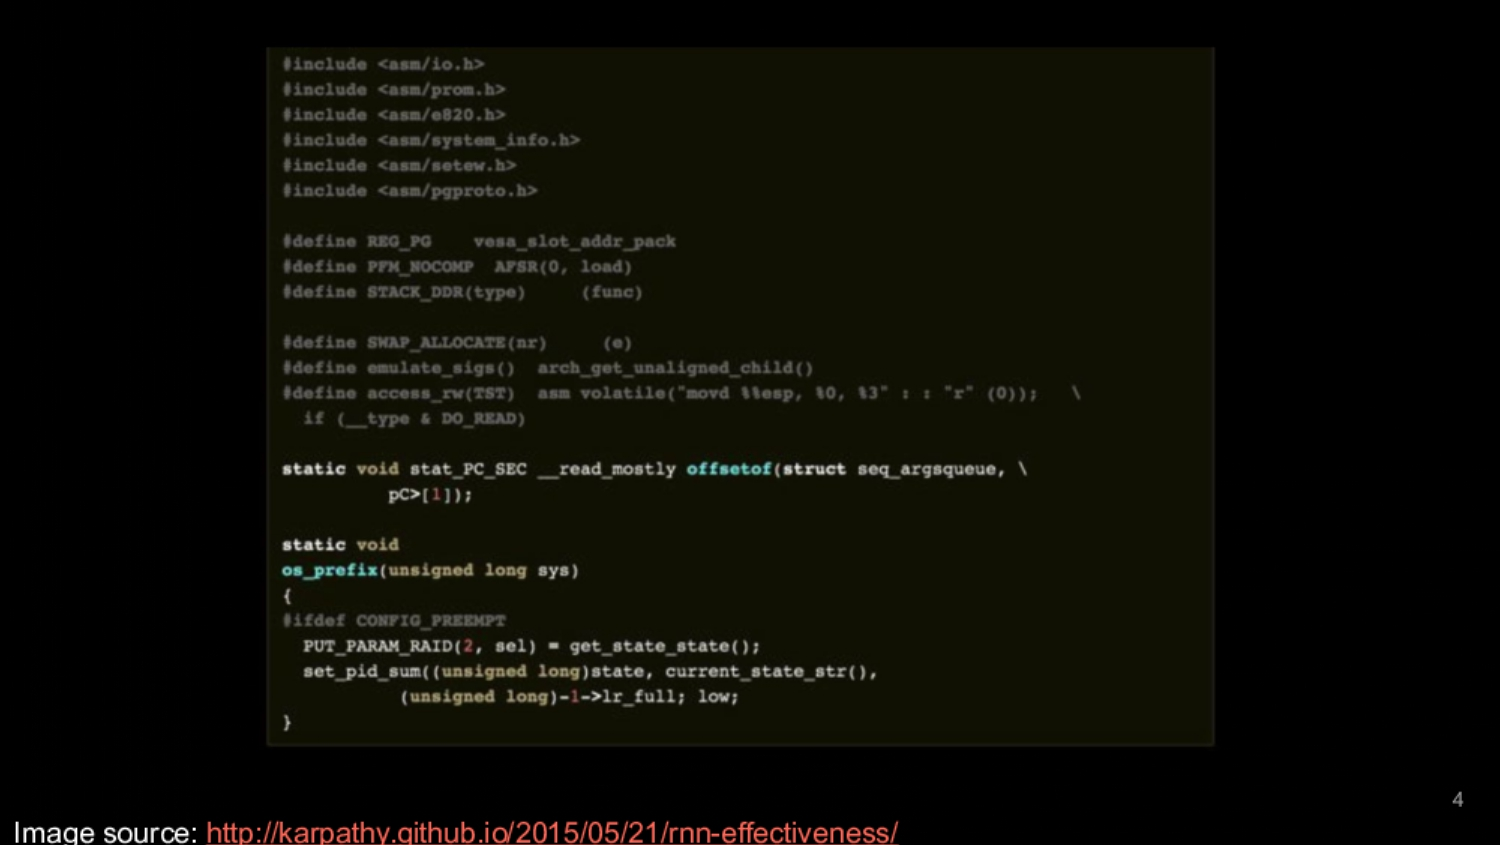

## 2. Принципы работы рекуррентных нейронных сетей.


Посмотрим на рекуррентную нейронную сеть. Что же это такое и как это работает?

Как мы уже говорили, слово в значительной мере определяется контекстом в котором оно встречается. Пытаясь понять какой-то текст, мы смотрим на него слева-направо. И, читая каждое новое слово, мы получаем более подробную картину о понимании смысла всего текста.

Пусть у нас есть некоторая последовательность, состоящая из токенов - слов, и мы уже прочитали $t-1$ слово и читаем слово с номером $t$. Можно сказать, что мы находимся в моменте времени t.

Допустим, что мы уже как-то научились превращать текст из $t-1$ слова в вектор фиксированной размерности (пока мы не знаем, как это делать, но можно предположить, что мы как-то этому научились).

Тогда $z_t$ - скрытое состояние, часть последовательности, которая есть на момент $t$ и описана в виде некоторого вектора.

$x_t$ - вектор нового слова, текущее представление о слове. При этом, мы считаем, что размеры $z_t$ и $x_t$  совпадают.

Как нам получить представление нового текста, состоящего из $t$ слов на основании известно информации о векторном представлении $t-1$ слова и вектора для нового слова? Давайте применим некоторое линейное преобразоввание!

Сконкатенируем $z_t$ и $x_t$ и умножим на некоторую матрицу, а затем применим функцию активации, тем самым преобразовав в новый вектор скрытого состояния.  Таким образом, мы задали **операцию обогащения контекста**.

В данном случае мы смогли учесть порядок слов.



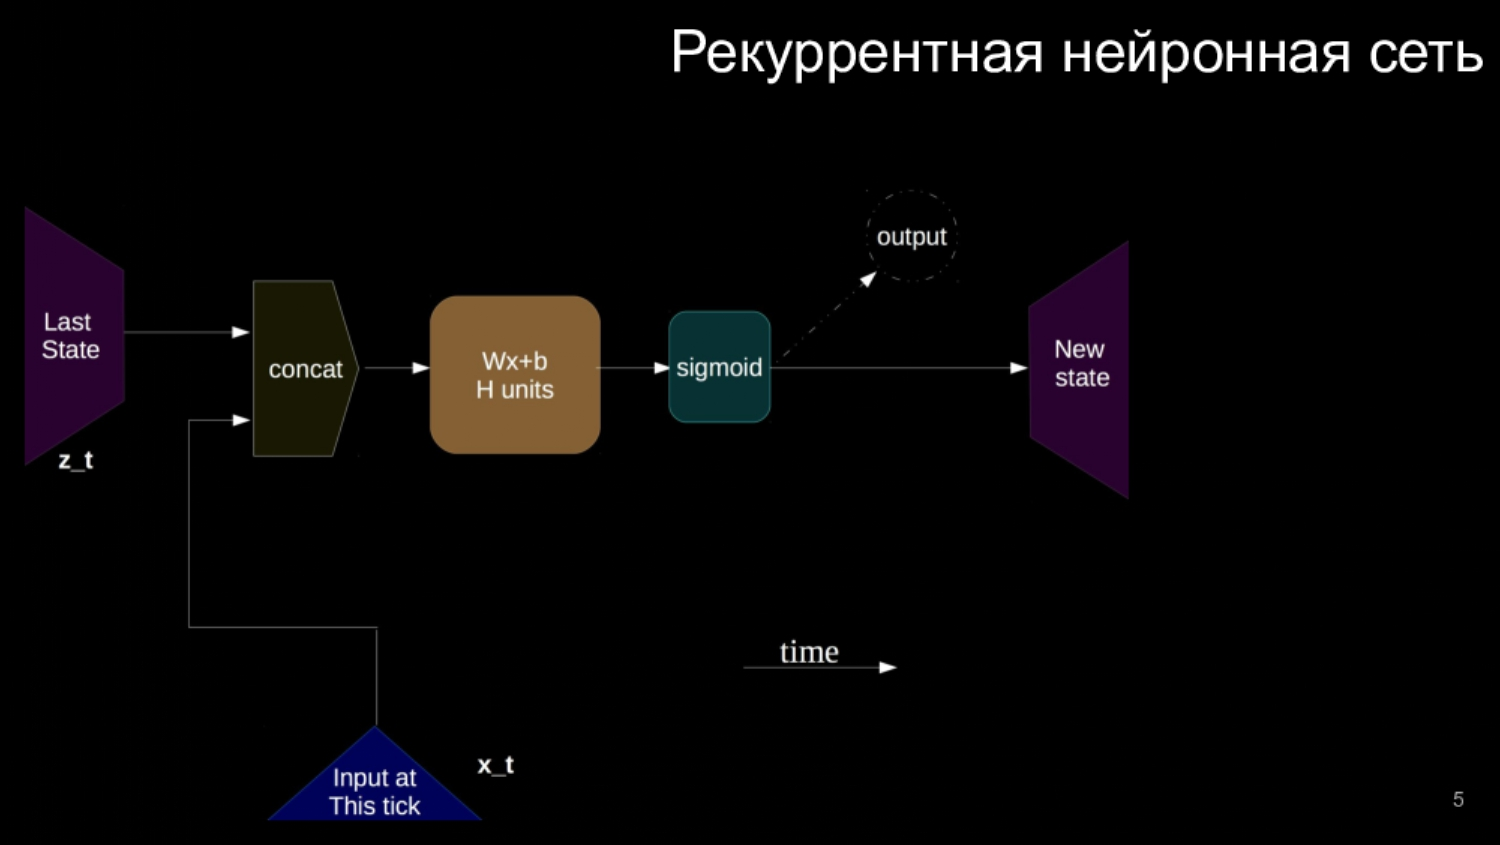

Теперь прочитаем новое слово. Здесь нам уже известно векторное представление для предыдущих $t$ слов. Поэтому, мы можем снова применить операцию обогащения контекста. И так далее для всех новых слов:

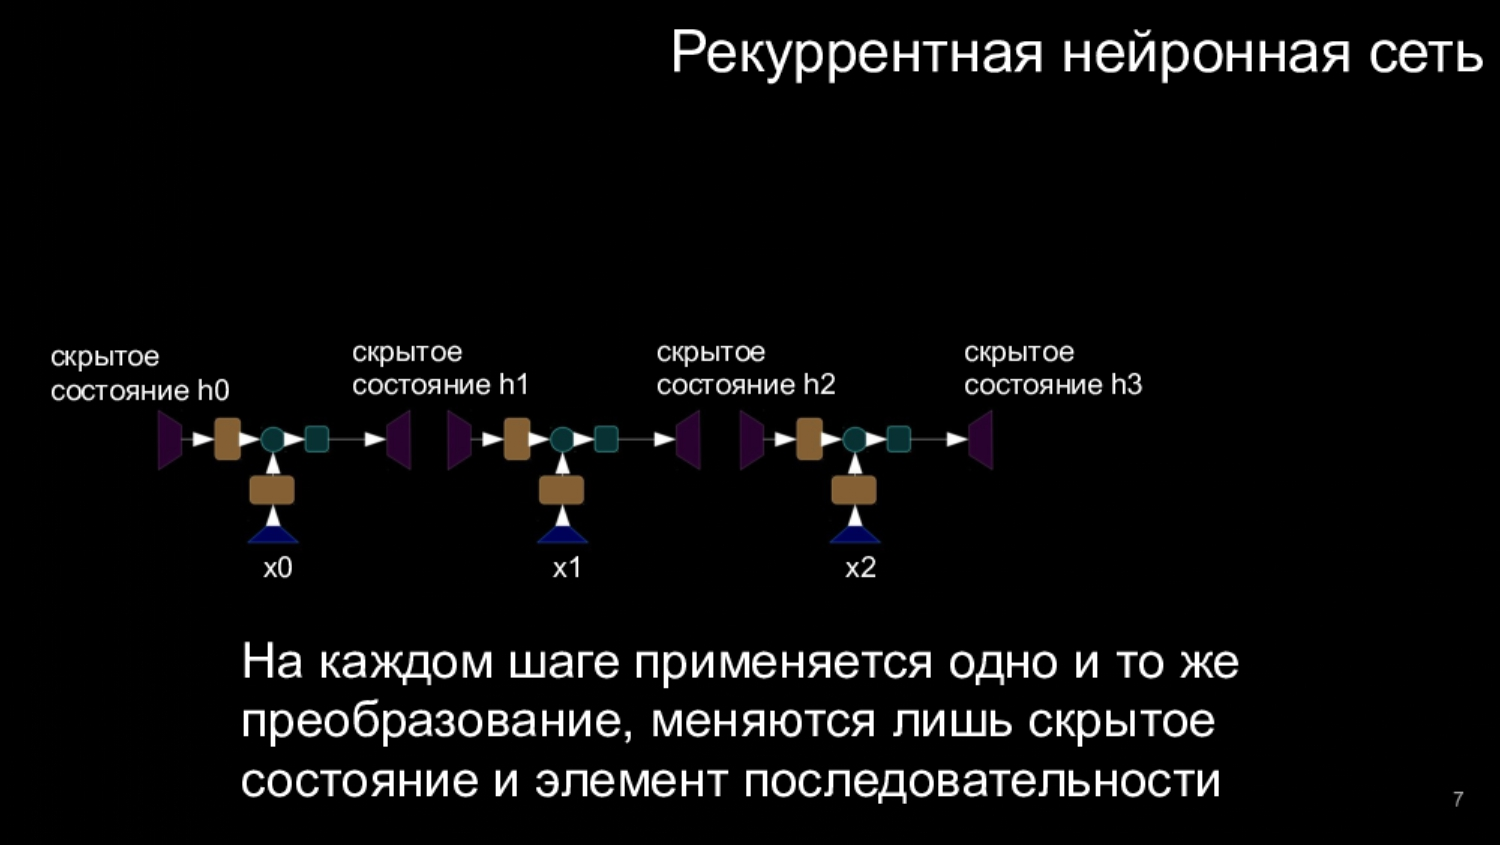

Теперь мы умеем производить векторизацию всей последовтельности, при этом учитывая порядок слов. При этом независимо от длины последовательности, векторное представление всей последовательности остается **фиксированным по размерности вектором** (вектором размерности скрытого состояния).

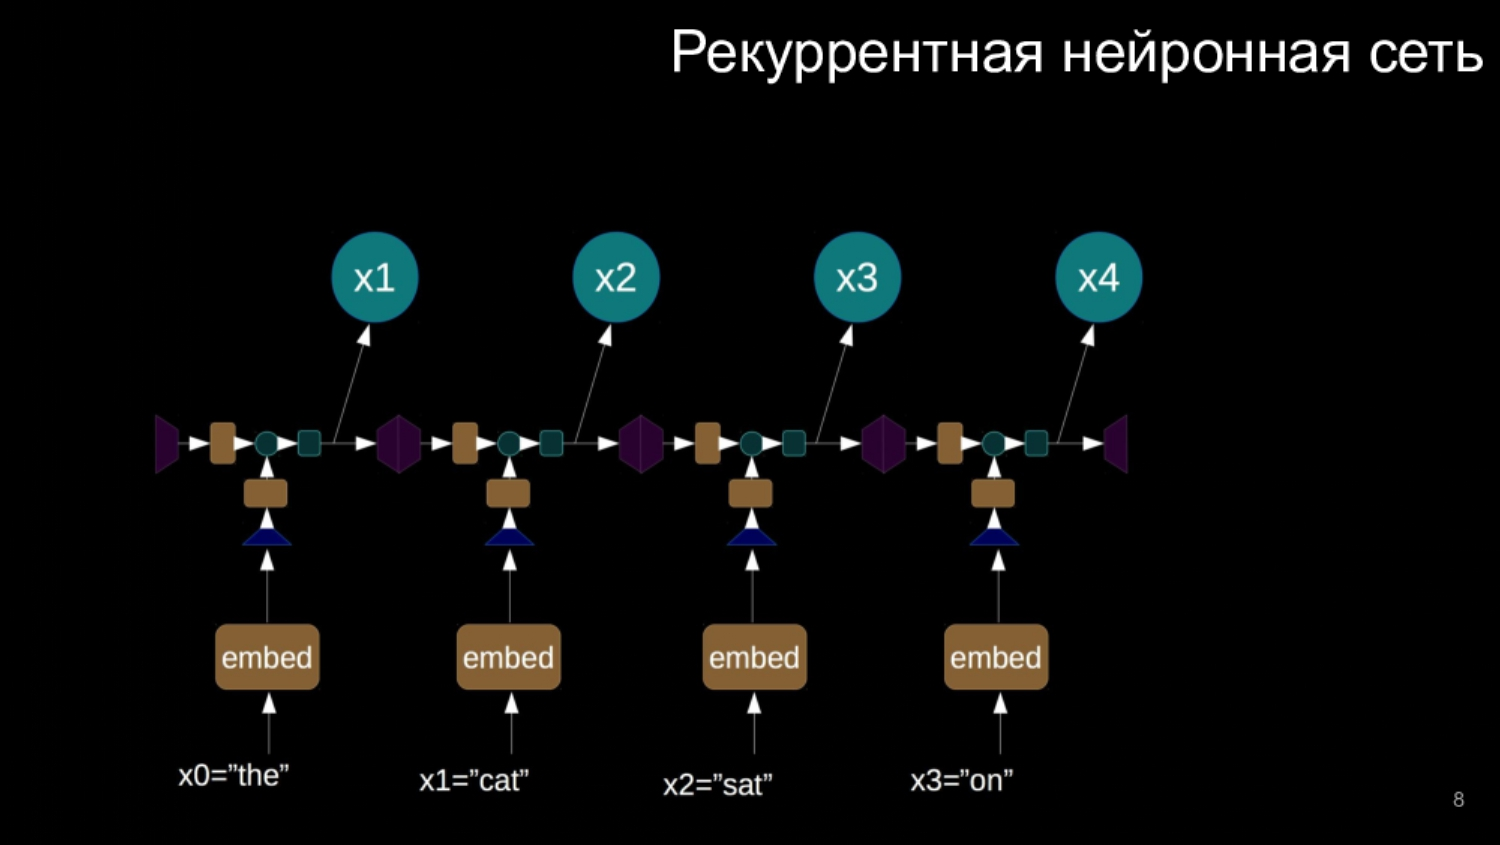

Задача языкового моделирования заключается в том, что мы **на каждом шаге хотим предсказать значение следующего шага**, т.е. зная текущую фразу хотим предсказать, какое слово будет следующим.

В общем случае задача (прямого) языкового моделирования предсказывает **вероятностное распределение по всем возможным токенам на следующем шаге при условии текущих токенов**.

На самом деле, этот подход очень похож на метод математической индукции, когда мы утверждаем, что если мы научились решать задачу для некоторого $t$, то мы можем решить аналогичную задачу для $t+1$. Т.е., научившись предсказывать слово с номером $t$ по известным предыдущим словам, мы сможем предсказать и слово $t+1$ по предыдущим словам.

Только для полноты картины, нам нужно понять, с чего начинать преобразования. Что должно быть передано самому первому преобразованию, когда нам вообще не известны никакие слова в тексте. Логично предположить, что в качестве начального значения можно использовать вектор из нулей. Мы же не знаем никакой предварительной информации о тексте, который мы будем читать, до того, как мы начали его читать.

Отсюда можно получить представление рекуррентной нейронной сети в виде формул:

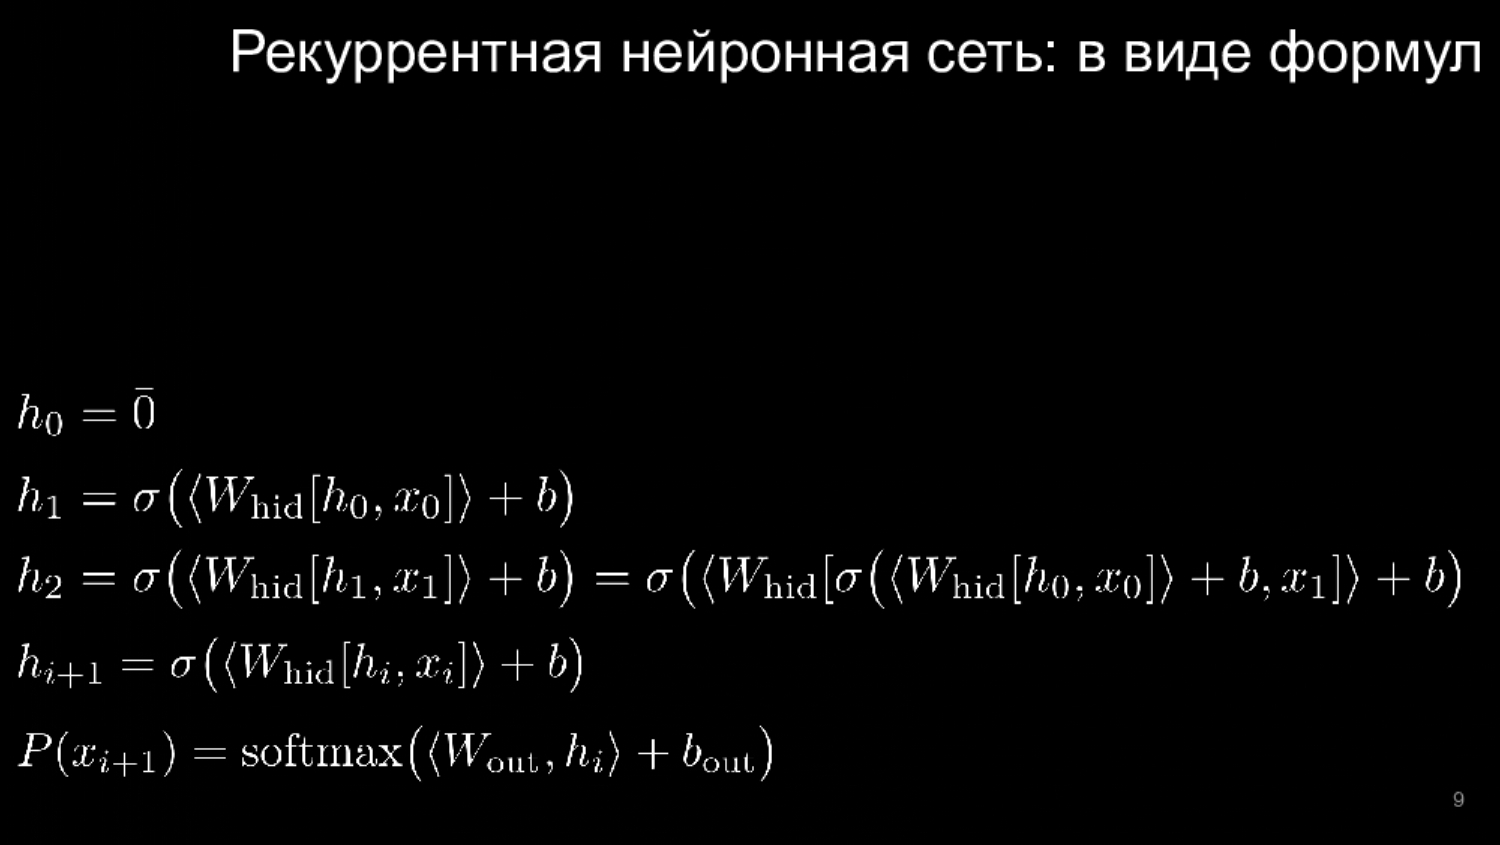

Последняя формула на слайде - формула для нахождения вероятности следующего элемента последовательности.

softmax - это специальная функция активации, некоторое обобщение функции sigmoid для многоклассовой классификации. Вы уже встречали её на прошлой лекции. Она задаётся формулой:

$$softmax(x_i)=\frac{e^{x_i}}{\sum_{j=1}^N e^{x_k}}$$

Эта функция используется, когда мы решаем многоклассовую классификацию. Тогда у сети будет $N$ выходов, где каждый выход $y_i$ представляет собой некоторую вероятность принадлежности входных данных классу с номером $i$. При этом все выходы нормируются таким образом, чтобы сумма вероятностей всех классов равнялась 1 (т.е. мы предполагаем, что вероятности каждого класса попарно независимы).

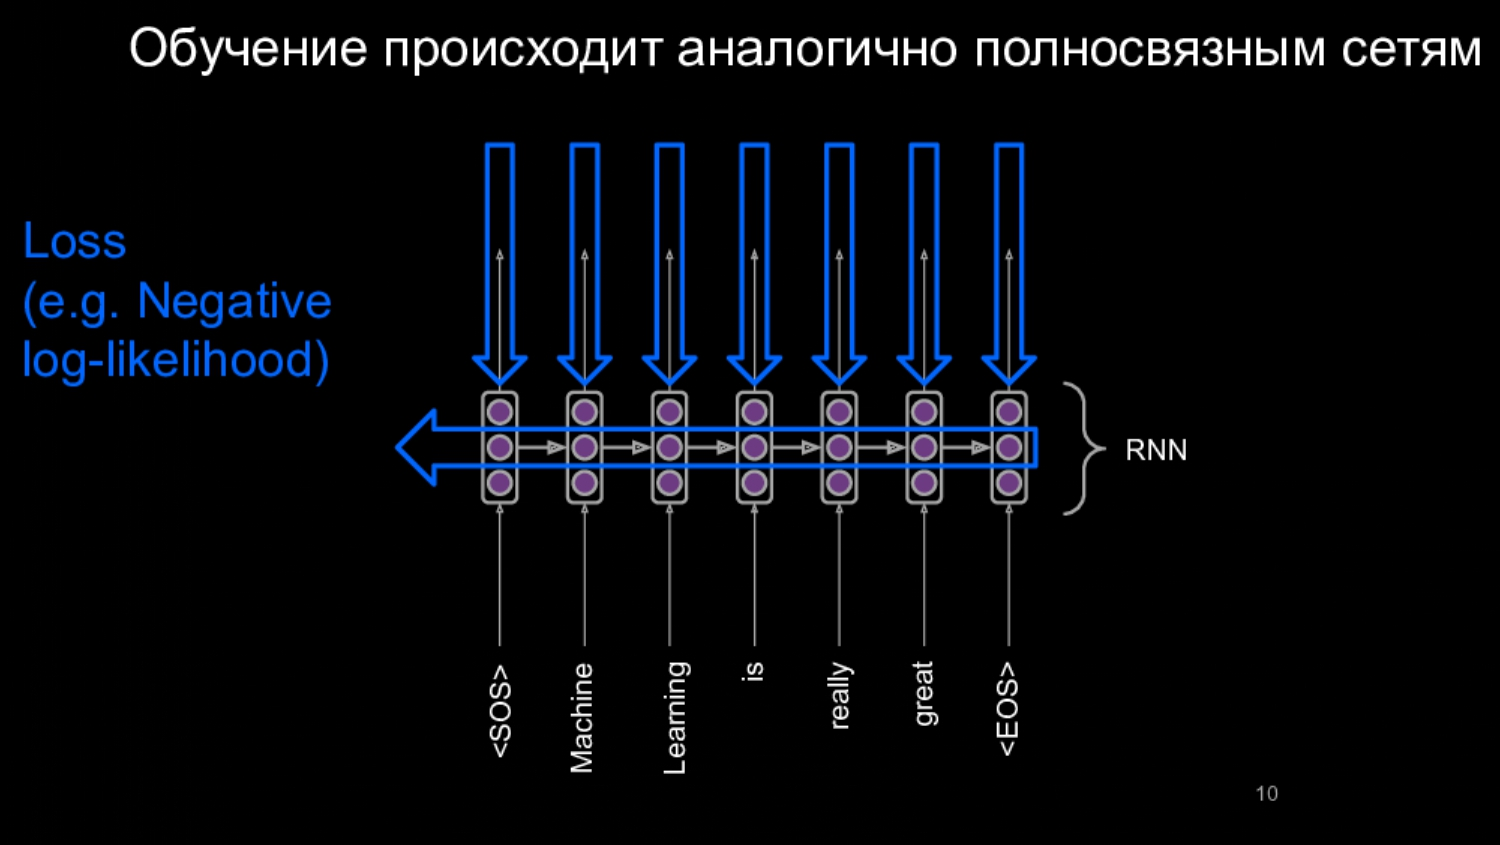

Важное замечание: **выбросы очень опасны для рекуррентных нейронных сетей!**

Т.е. если мы при анализе текста получим какое-то неожиданное слово, это очень сильно повлияет на предсказание нашей сети (в частности, это повлияет на предсказание дальнейших слов). В следующей лекции мы вернёмся к этой проблеме.

И еще одна красивая картинка, иллюстрирующая работу рекуррентных нейронных сетей.

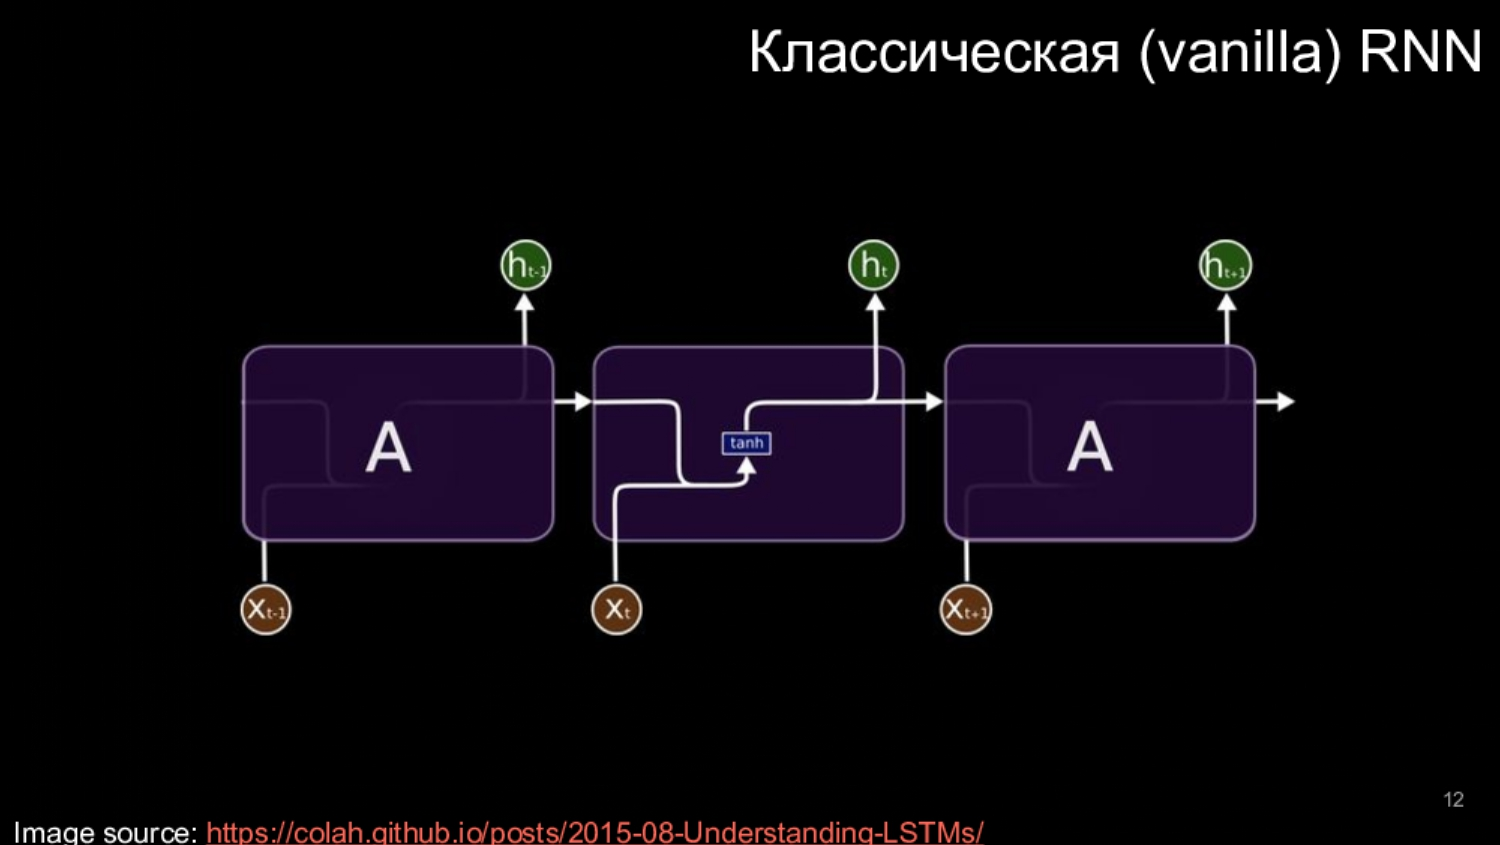

На каждом шаге по нашей последовательности шкала, в которой находится скрытое состояние, меняется. Но мы подаём результат этого состояния следующему блоку. Но преобразование на каждом шаге у нас фиксировано. Значит, в каждом скрытом состоянии мы должны генерировать значения из ограниченного множества, чтобы можно было их корректно передать дальше. Поэтому нужно использовать преобразования, которые будут ограничивать область значений. Преобразование должно работать с фиксированным пространством входа. Именно поэтому используем сигмоиду и tanh, а не ReLu (ее можно использовать с нормировкой).

## 3. Предобработка текстовых данных для задачи языкового моделирования.
Рассмотрим набор данных, который представляет собой список имен. Каждая последовательность – отдельное имя. В качестве токенов будем рассматривать отдельные символы.

In [ ]:
import os                                                                         # импортируем часть библиотеки для взаимодействия с данными на
                                                                                  # компьютере и для доступа к окружению, где запущен notebook
from random import sample                                                         # random - часть библиотеки, которая отвечает за случайные числа

import numpy as np                                                                # библиотека для работы с векторами и матрицами

import torch                                                                      # тут все нейронные сети
import torch.nn as nn                                                             # тут все блоки нейронных сетей, слои
import torch.nn.functional as F                                                   # функции, которые нам пригодятся

import matplotlib.pyplot as plt                                                   # для построения графиков
from IPython.display import clear_output                                          # для интерактивного построения графиков
                                                                                  # clear_output позволяет покадрово рисовать график сходимости

Загрузим и предобработаем данные:

In [ ]:
! wget https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/names.txt -O names.txt  # скачиваем names.txt

--2023-04-05 11:32:10--  https://raw.githubusercontent.com/MSUcourses/Data-Analysis-with-Python/main/Deep%20Learning/Files/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 55868 (55K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>]  54.56K  --.-KB/s    in 0.01s   

2023-04-05 11:32:11 (5.07 MB/s) - ‘names.txt’ saved [55868/55868]



In [ ]:
!head names.txt                                                                   # через ! можно обратиться непосредственно к консоли
                                                                                  # head позволяет увидеть первые несколько элементов,
                                                                                  # которые отсортированы лексикографически

Abagael
Abagail
Abbe
Abbey
Abbi
Abbie
Abby
Abigael
Abigail
Abigale


In [ ]:
# Обратимся к задаче языкового моделирования на примере имен
# в данном случае токенами будут символы
# задача - научиться генерировать слова последовательности,
# которые являются именами, посимвольно
start_token = " "                                                                 # технический токен (здесь это пробел), с которого начинается
                                                                                  # каждая последовательность

with open("names.txt") as f:                                                      # открыли файл
    names = f.read()[:-1].split('\n')                                             # names - все, что есть, разделенное по переносу строки
    names = [start_token + line for line in names]                                # к каждому элементу последовательности добавили пробел в начало

Как видим, в датасете 7944 примера. Обратите внимание, каждая последовательность начинается с пробела.

In [ ]:
print ('n_samples = ',len(names))
for x in names[::1000]:                                                           # выводим каждый тысячный элемент из множества слов
    print (x)

n_samples =  7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


Рассмотрим распределение длин последовательностей:

max_length = 16


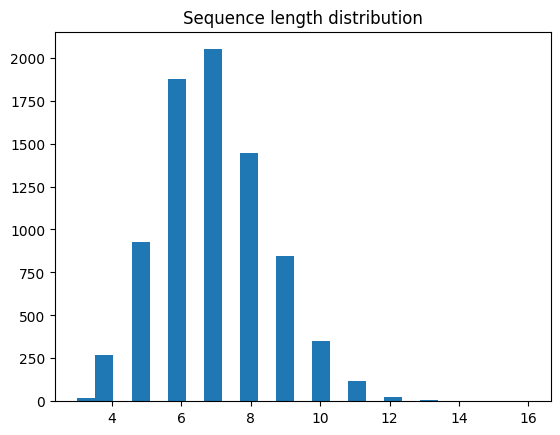

In [ ]:
MAX_LENGTH = max(map(len, names))                                                 # map применяет конкретную функцию к списку или любому итерируемогу объекту
                                                                                  # в данном случае происходит подсчет длины каждого элемента множества names
                                                                                  # и поиск максимума от результата
print("max_length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)),bins=25);                                          # hist - гистограмма
                                                                                  # считаем количество вхождений именно для списка

#### Предобработка текста

Для начала построим "словарь" из всех уникальных токенов и пронумеруем их. Тогда мы можем кодировать входные данные как последовательность их индексов символов. Например, имя "Aboba" будет представлено как `[0, 1, 15, 1, 0]`.

In [ ]:
set('aaaaaabbbbcc')                                                               # вывод всех уникальных элементов последовательной структуры

{'a', 'b', 'c'}

In [ ]:
tokens = set() # <set of all unique characters in the dataset>

for name in names:                                                                # итерируемся по всем именам
    tokens.update(set(name))                                                      # считаем set от последовательности и обновляем множество,
                                                                                  # добавляя в него все уникальные новые токены из нового имени
tokens = list(tokens)                                                             # оборачиваем все в список

num_tokens = len(tokens)
print ('num_tokens = ', num_tokens)

num_tokens =  55


In [ ]:
# <dictionary of symbol -> its identifier (index in tokens list)>
token_to_id = {
    token: idx for idx, token in enumerate(tokens)                                # пронумеровали все токены, каждому токену соответствует его
}                                                                                 # порядковый номер

Теперь каждому соответствует уникальный индекс.

Наконец, реализуем функцию для преобразования список имен в матричное представление, которое в дальнейшем будет использоваться в качестве батча.
Т.к. тексты могут быть различной длины, дополним их до максимальной длины `max_len` или до длины самого длинного имени из выборки, если этот параметр не указан.

In [ ]:
def to_matrix(names, max_len=None, pad=token_to_id[' '], dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""

    max_len = max_len or max(map(len, names))                                     # считаем макс длину среди всех имеющихся имен и используем ее
                                                                                  # или макс длину, заданную извне (если такая есть)
    names_ix = np.zeros([len(names), max_len], dtype) + pad                       # матрица размером [количество имен х макс длина] из нулей
                                                                                  # затем заменяем нули на индекс падтокена
                                                                                  # pad - технический токен (в данном случае – пробел), который приводит
                                                                                  # последовательности к одинаковой длине

    for i in range(len(names)):                                                   # итерируемся по всем именам
        line_ix = [token_to_id[c] for c in names[i]]                              # и для каждого элемента имени переводим токен (символ)
                                                                                  # в соответствующий индекс
        names_ix[i, :len(line_ix)] = line_ix                                      # записываем в матрицу новую строку из индексов

    if not batch_first: # convert [batch, time] into [time, batch]
        names_ix = np.transpose(names_ix)

    return names_ix

Рассмотрим пример:

In [ ]:
print('\n'.join(names[::1000]))
print(to_matrix(names[::1000]))

 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy
[[32  3 52 27 50 27  4 18 32]
 [32 44 18 27  9  4  1 51 27]
 [32 17 18 41  9 39 32 32 32]
 [32 38  7 18  7 27 20  4 32]
 [32 26  9  7  1  1  7  4 32]
 [32 17  4  4 51 27 32 32 32]
 [32 17  7 41 54 27 20 20  4]
 [32 26  7 50 50 39 32 32 32]]


Подсветим все позиции, которые соответствуют пробелам:

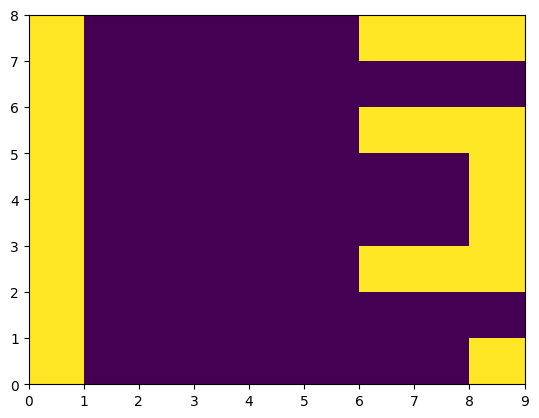

In [ ]:
plt.pcolormesh(to_matrix(names[::1000])==token_to_id[' '])

## 4. Построение рекуррентной нейронной сети для задачи языкового моделирования.
Наконец, перейдем непосредственно к построению рекуррентной нейронной сети. Сегодня мы реализуем ее с нуля. Готовый вариант доступен, например, в `torch.nn.RNN`.

Рекуррентную нейронную сеть можно рассматривать как последовательное применение плотного слоя к входу $x_t$ и предыдущему состоянию `rnn` $h_t$.
<img src="https://raw.githubusercontent.com/neychev/small_DL_repo/master/rnn.png" width=480>

Также нам понадобятся:
* Embedding-слой, который преобразует индекс токена $x_t$ в вектор. Принцип его действия аналогичен word2vec, который был рассмотрен ранее. Основное отличие: параметры обучаются непосредственно на данную задачу.
* Выходной слой, который предсказывает вероятность следующего токена.

In [ ]:
embed = nn.Embedding(10, 4)                                                       # 10 - число эмбеддингов, 4 - их размерность

In [ ]:
params = next(iter(embed.parameters()))                                           # embed.parameters() - генератор параметров

In [ ]:
params

Parameter containing:
tensor([[ 2.0661,  0.5582, -0.4227, -0.3584],
        [-0.4269, -2.2143, -0.4346,  0.4921],
        [-0.2505,  0.4476, -0.0210, -0.9895],
        [ 0.5706, -0.8394,  1.9599, -2.4252],
        [ 0.8035,  0.2601, -1.6738, -0.3398],
        [-0.6547, -2.0425, -1.2964,  0.2270],
        [ 1.5337,  0.4837,  0.6977, -0.2401],
        [ 0.4653,  1.3172,  0.6320, -1.3185],
        [-2.1439,  0.9681, -1.5748,  2.1302],
        [ 0.4612,  0.0573,  0.0658, -0.4133]], requires_grad=True)

In [ ]:
embed(torch.LongTensor([1]))                                                      # вектор для 1 токена

tensor([[-0.4269, -2.2143, -0.4346,  0.4921]], grad_fn=<EmbeddingBackward0>)

In [ ]:
type(torch.LongTensor([1]))

torch.Tensor

In [ ]:
vector = torch.zeros(10)                                                          # создадим one-hot вектор
vector[1] = 1
print(vector)

tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.])


In [ ]:
torch.matmul(vector, params)                                                      # умножение one-hot вектора на параметры

tensor([-0.4269, -2.2143, -0.4346,  0.4921], grad_fn=<SqueezeBackward4>)

In [ ]:
embed(torch.LongTensor([1]))                                                      # результат применения эмбеддинга
# видим, что torch.matmul(vector, params) и embed(torch.LongTensor([1])) дали один результат, только torch.matmul(vector, params) "дороже"

tensor([[-0.4269, -2.2143, -0.4346,  0.4921]], grad_fn=<EmbeddingBackward0>)

In [ ]:
# Рекуррентная "ячейка"
class CharRNNCell(nn.Module):
    """
    Implement the scheme above as torch module
    """
    def __init__(self, num_tokens=len(tokens), embedding_size=16, rnn_num_units=64):  # конструктор, где мы задаем количество уникальных токенов,
                                                                                      # размерность скрытого пространства эмбеддингов и
                                                                                      # размерность вектора контекста
        super(self.__class__,self).__init__()
        self.num_units = rnn_num_units

        self.embedding = nn.Embedding(num_tokens, embedding_size)                     # задаем эмбеддинг
        self.rnn_update = nn.Linear(embedding_size + rnn_num_units, rnn_num_units)    # линейный слой преобразования предыдущего состояния и нового входа в новое состояние
        self.rnn_to_logits = nn.Linear(rnn_num_units, num_tokens)                     # и классификатор (линейный слой из скрытого состояния в
                                                                                      # размерность словаря)

    def forward(self, x, h_prev):
        """
        This method computes h_next(x, h_prev) and log P(x_next | h_next)
        We'll call it repeatedly to produce the whole sequence.

        :param x: batch of character ids, containing vector of int64
        :param h_prev: previous rnn hidden states, containing matrix [batch, rnn_num_units] of float32
        """
        # get vector embedding of x
        # batch, seq leng, emb dim
        x_emb = self.embedding(x)                                                 # отображаем индекс икса в вектор

        # compute next hidden state using self.rnn_update
        x_and_h = torch.cat([h_prev, x_emb], dim=-1) # YOUR CODE HERE             # сконкатенировали x и h по -1 размерности (размерности признаков)
        h_next = self.rnn_update(x_and_h) # YOUR CODE HERE                        # применяем линейный слой к этому конкатенированному вектору

        h_next = torch.tanh(h_next) # YOUR CODE HERE                              # и применяем тангенс

        assert h_next.size() == h_prev.size()                                     # проверяем совпадение размерностей

        #compute logits for next character probs
        logits = self.rnn_to_logits(h_next) # YOUR CODE                           логиты - ненормированные вероятности. А где softmax? Добавим его ниже.

        return h_next, logits

    def initial_state(self, batch_size):
        """ return rnn state before it processes first input (aka h0) """
        return torch.zeros(batch_size, self.num_units, requires_grad=True)        # инициализируем скрытые состояния (изначально из нулей)

In [ ]:
char_rnn = CharRNNCell()
criterion = nn.NLLLoss()

Теперь реализуем функцию для обработки каждого следующего элемента последовательности:

In [ ]:
def rnn_loop(char_rnn, batch_ix):
    """
    Computes log P(next_character) for all time-steps in names_ix
    :param names_ix: an int32 matrix of shape [batch, time], output of to_matrix(names)
    """
    batch_size, max_length = batch_ix.size()                                      # размер батча, макс длина
    hid_state = char_rnn.initial_state(batch_size)                                # текущее скрытое состояние из инициализатора
    logprobs = []                                                                 # логарифмы вероятностей

    for x_t in batch_ix.transpose(0,1):                                           # итерируемся по батчу
        hid_state, logits = char_rnn(x_t, hid_state)  # <-- here we call your one-step code   берем текущее скрытое состояние, новый x_t
                                                                                            # и получаем логиты след токена с помощью RNN
        logprobs.append(F.log_softmax(logits, -1))                                # добавили в logprobs логиты, применив log_softmax
                                                                                  # используем логарифм от softmax, чтобы не получать большие значения от экспоненты

    return torch.stack(logprobs, dim=1)                                           # затем это укладываем в одну "стопочку", чтобы посчитать Loss
                                                                                  # logprobs - ось батча, dim=1 - ось времени

Наконец, проверим, что все работает:

In [ ]:
batch_ix = to_matrix(names[:5])                                                   # батч индекс, все преобразовали в батч
batch_ix = torch.tensor(batch_ix, dtype=torch.int64)                              # потом преобразовали в тензор

logp_seq = rnn_loop(char_rnn, batch_ix)

assert torch.max(logp_seq).data.numpy() <= 0                                     # Проверяем, что мы получили корректные предсказания логарифма вероятности слудующего токена
                                                                                 # Вероятность - неотрицательное число от 0 до 1. Значит, логарифм должен быть неотрицательным
assert tuple(logp_seq.size()) ==  batch_ix.shape + (num_tokens,)                 # Проверяем соответствия размерностей

#### Обучение языковой модели

Т.к. задача предсказания следующего токена – это задача классификации, в качестве функции потерь будет выступать уже знакомая нам кросс-энтропия.

В качестве "истинных значений" мы будем использовать `batch_ix[:, 1:]` - матрицу из индексов токенов, сдвинутых на один шаг вперед.

In [ ]:
predictions_logp = logp_seq[:, :-1]                                               # все кроме последнего предсказания, т.к. в конце последовательности нам не нужно ничего предсказывать
actual_next_tokens = batch_ix[:, 1:]                                              # наши правильные ответы (все что есть, начиная с 1 шага), исключаем первый шаг, т.к. в начале мы находились в нулевом состоянии и ничего не предсказывали

loss = criterion(                                                                 # считаем функцию ошибки от предсказаний и истинных значений
    predictions_logp.contiguous().view(-1, num_tokens),                           # вытягиваем все в один батч (т.е. из размерности (batch, time, prob) переходим к (batch*time, prob))
    actual_next_tokens.contiguous().view(-1)
)

loss.backward()

Финальная проверка:

In [ ]:
# для всех весов в параметрах проверяем, что
# градиент не None и макс абсолютного значения градиента не равен 0
for w in char_rnn.parameters():
    assert w.grad is not None and torch.max(torch.abs(w.grad)).data.numpy() != 0, \
        "Loss is not differentiable w.r.t. a weight with shape %s. Check forward method." % (w.size(),)

#### Обучение модели

Сама процедура обучения практически не отличается от предыдущих. Единственное различие заключается в том, что в этот раз мы семплируем строки переменной длины, а затем приводим их к единой длине внутри одного батча.

In [ ]:
char_rnn = CharRNNCell()
opt = torch.optim.Adam(char_rnn.parameters())                                     # используем оптимизатор Adam
history = []                                                                      # создали список для истории (записи значений функции потерь)

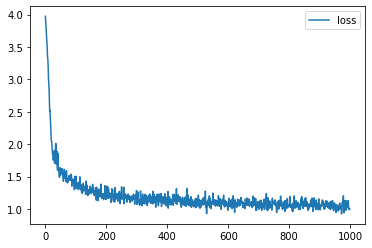

In [ ]:
MAX_LENGTH = 16

for i in range(1000):                                                             # всего 1000 итераций
    opt.zero_grad()                                                               # занулили градиенты

    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)                   # выбрали 32 случайных элемента из всех имен
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)                          # преобразовали в тензор

    logp_seq = rnn_loop(char_rnn, batch_ix)                                       # получили последовательность logp

    # Считаем loss - см. выше
    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )

    # Обучение методов backprop
    loss.backward()                                                               # посчитали градиенты
    opt.step()                                                                    # сделали шаг

    # код отрисовки графика
    history.append(loss.item())
    if (i+1)%100==0:                                                              # на каждом сотом шаге обновляем график
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."     # проверяем, что среднее значение за последние 10 шагов больше
                                                                                  # среднего значения за первые 10 шагов (если нет – модель не сошлась)

#### Генерация имен
После обучения языковой модели (а обученная нейросеть является языковой моделью) перейдем к генерации данных.
Для этого воспользуемся функцией ниже:

In [ ]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    x_sequence = [token_to_id[token] for token in seed_phrase]                    # преобразуем seed_phrase в последовательность индексов токенов
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)
    hid_state = char_rnn.initial_state(batch_size=1)

    #feed the seed phrase, if any
    for i in range(len(seed_phrase) - 1):                                         # если длина seed_phrase > 1, то пробежимся по ней
        hid_state, _ = char_rnn(x_sequence[:, i], hid_state)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        hid_state, logits = char_rnn(x_sequence[:, -1], hid_state)                # новое скрытое состояние и логит для след токена - это
                                                                                  # последний элемент последовательности и текущее скрытое состояние
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0]          # считаем вероятность: softmax от текущих логитов
                                                                                  # temperature отвечает за случайность (гиперпараметр)

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(num_tokens,p=p_next)                           # из всех токенов с распределением p_next
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)                      # добавляем к последовательности

    return ''.join([tokens[ix] for ix in x_sequence.data.numpy()[0]])             # возвращаем все, сконкатенировав через пустую строку

Рассмотрим несколько случайных примеров:

In [ ]:
for _ in range(10):
    print(generate_sample(char_rnn, temperature=1.))

 Bardie         
 Varrey         
 Mallee         
 Jabay          
 Heelcee        
 Buthdlad       
 Suskcae        
 Fann           
 Rhebilev       
 Blabeini       


Также мы можем задать некоторую подстроку в для инициализации начального состояния нашей модели.

In [ ]:
for _ in range(50):
    print(generate_sample(char_rnn, seed_phrase=' Serg', temperature=1.))

 Sergiga        
 Sergerm        
 Sergenn        
 Sergy          
 Sergion        
 Sergina        
 Sergor         
 Sergstha       
 Serghele       
 Sergoslo       
 Sergy          
 SergarrF       
 Sergine        
 Sergie         
 Sergi          
 Sergy          
 Sergia         
 Sergala        
 Sergich        
 Sergy          
 Sergy          
 Sergind        
 Sergan         
 Sergi          
 Sergie       n 
 Sergal         
 Sergif         
 Sergi          
 Serga          
 Sergec         
 Sergar         
 Sergasno       
 Serg na        
 Sergive        
 Sergyn         
 Serglind       
 Sergeba        
 Serguslon      
 Sergtia        
 Sergky         
 Serge          
 Sergere        
 Sergie         
 Sergia         
 Sergia         
 Serger         
 Sergiend       
 Sergie         
 Sergeyy        
 Sergy          


#### Использование готовых модулей

Только что мы реализовали RNN самостоятельно, что полезно, но требует некоторого времени. Конечно, на практике обычно используются уже готовые реализации.

В `torch` доступны два варианта классической RNN:
* `nn.RNNCell(emb_size, rnn_num_units)`, которая реализует один шаг RNN. Аналог того класса, что мы реализовали выше.
* `nn.RNN(emb_size, rnn_num_units)`, которая самостоятельно обрабатывает всю последовательность (аналог `nn.RNNCell` + `rnn_loop`).


Также существуют `nn.LSTMCell` и `nn.LSTM`, `nn.GRUCell` и `nn.GRU`.

Воспользуемся высокоуровневым API для получения аналогичных результатов:

In [ ]:
class CharRNNLoop(nn.Module):
    def __init__(self, num_tokens=num_tokens, emb_size=16, rnn_num_units=64):
        super(self.__class__, self).__init__()
        self.emb = nn.Embedding(num_tokens, emb_size)
        self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_tokens)

    def forward(self, x):
        assert isinstance(x.data, torch.LongTensor)
        h_seq, _ = self.rnn(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        next_logp = F.log_softmax(next_logits, dim=-1)
        return next_logp

model = CharRNNLoop()
opt = torch.optim.Adam(model.parameters())
history = []

In [ ]:
# the model applies over the whole sequence
batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
batch_ix = torch.LongTensor(batch_ix)

logp_seq = model(batch_ix)

loss = F.nll_loss(logp_seq[:, 1:].contiguous().view(-1, num_tokens),
                  batch_ix[:, :-1].contiguous().view(-1))

loss.backward()

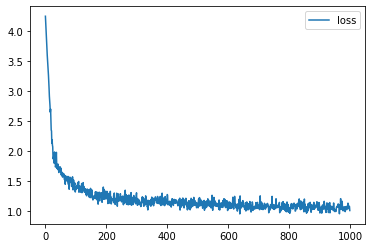

In [ ]:
MAX_LENGTH = 16

for i in range(1000):
    batch_ix = to_matrix(sample(names, 32), max_len=MAX_LENGTH)
    batch_ix = torch.tensor(batch_ix, dtype=torch.int64)

    logp_seq = model(batch_ix)

    predictions_logp = logp_seq[:, :-1]
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, num_tokens),
        actual_next_tokens.contiguous().view(-1)
    )

    # train with backprop
    loss.backward()
    opt.step()
    opt.zero_grad()

    history.append(loss.data.numpy())
    if (i+1)%100==0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."

#### Выводы:
* Рекуррентные нейронные сети позволяют работать с последовательностями переменной длины, обрабатывая по одному элементу за шаг.
* Задача языкового моделирования может рассматриваться как задача классификации, т.к. множество токенов конечно.
* Даже сложные модели могут быть реализованы с нуля. Но многие модули уже доступны в самом фреймворке.